#EEG-signal classification for the Detection of epileptic seizure

Hassouna Malek ET Trigui Hatem 

### Importing the libraries

In [137]:
import pywt
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, mean_squared_error


### Data Pre-Processing

In [138]:
def process_eeg_file(file_path, label):
    data = np.loadtxt(file_path)
    chunk_size = 177
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]
    labeled_chunks = [(chunk, label) for chunk in chunks]
    return labeled_chunks

def process_dataset_folder(folder_path, label):
    dataset = []
    for file_name in os.listdir(folder_path):
        if file_name.upper().endswith(".TXT"):
            file_path = os.path.join(folder_path, file_name)
            dataset.extend(process_eeg_file(file_path, label))
    return dataset


In [139]:
import os  # Ajout d'import si ce n'était pas inclus
import numpy as np
import pandas as pd  # Assurez-vous que ces imports sont présents

class_folders = {
    1: 'C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set A/',
    2: 'C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set B/',
    3: 'C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set C/',
    4: 'C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set D/',
    5: 'C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set E/',
}

full_dataset = []

for label, folder in class_folders.items():
    folder_path = os.path.join("./data", folder)  
    class_dataset = process_dataset_folder(folder_path, label) 
    full_dataset.extend(class_dataset)
    print(f"Class {label}, Folder {folder}: {len(class_dataset)} lines")

np.random.shuffle(full_dataset)

X = [entry[0] for entry in full_dataset]
y = np.array([entry[1] for entry in full_dataset])

max_length = max(len(chunk) for chunk in X)
X_padded = np.array([np.pad(chunk, (0, max_length - len(chunk))) for chunk in X])

columns = [f"X{i}" for i in range(1, max_length + 1)] + ["y"]
df = pd.DataFrame(np.column_stack([X_padded, y]), columns=columns)

output_path = 'C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/datafinal.csv'
df.to_csv(output_path, index=False)
print(f"CSV file saved successfully at: {output_path}")


Class 1, Folder C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set A/: 2400 lines
Class 2, Folder C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set B/: 2400 lines
Class 3, Folder C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set C/: 2400 lines
Class 4, Folder C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set D/: 2400 lines
Class 5, Folder C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/Set E/: 2400 lines
CSV file saved successfully at: C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/datafinal.csv


In [140]:
ESR = pd.read_csv('C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/datafinal.csv')

In [141]:
ESR.head()
ESR = ESR.drop(columns = ESR.columns[0])

### Exploratory Data Analysis

In [142]:
ESR.isnull().sum()

X2      0
X3      0
X4      0
X5      0
X6      0
       ..
X174    0
X175    0
X176    0
X177    0
y       0
Length: 177, dtype: int64

The dataset contains 178 columns (X2 to X178) plus the target column y.
Each value in the result indicates how many missing values are present in that column.
For example:
X2 has 0 missing values.
X3 has 0 missing values.
All columns have 0 missing values, which means there are no missing values in the entire dataset.

In [143]:
ESR.describe()

,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,y
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,-8.334667,-9.202417,-10.436000,-11.430833,-12.322667,-12.814583,-12.665500,-11.668333,-10.541833,-9.795083,...,-6.451417,-7.164000,-7.782333,-7.996667,-7.993167,-8.038917,-8.040583,-7.753333,-7.447083,3.000000
std,168.651628,169.951623,171.326287,170.135922,166.758231,166.538977,168.824472,169.983614,168.858382,165.889155,...,164.512100,164.010894,162.151717,161.253907,161.086195,160.371034,158.599734,158.784674,160.391282,1.414272
min,-1866.000000,-1863.000000,-1865.000000,-1822.000000,-1868.000000,-1805.000000,-1838.000000,-1763.000000,-1829.000000,-1727.000000,...,-1852.000000,-1860.000000,-1861.000000,-1845.000000,-1820.000000,-1857.000000,-1843.000000,-1783.000000,-1870.000000,1.000000
25%,-55.000000,-55.000000,-55.000000,-56.000000,-57.000000,-57.000000,-56.000000,-57.000000,-56.000000,-56.000000,...,-50.000000,-49.000000,-49.000000,-49.000000,-50.000000,-50.000000,-51.000000,-51.000000,-50.250000,2.000000
50%,-7.000000,-8.000000,-8.000000,-8.500000,-8.000000,-8.000000,-9.000000,-9.000000,-9.000000,-9.000000,...,-4.000000,-4.000000,-5.000000,-4.000000,-5.000000,-5.000000,-4.000000,-4.000000,-3.000000,3.000000
75%,36.000000,37.000000,37.000000,35.000000,35.000000,35.000000,34.000000,33.000000,32.250000,33.000000,...,33.000000,32.000000,33.000000,34.000000,33.000000,32.000000,33.000000,34.000000,34.000000,4.000000
max,1460.000000,1413.000000,1501.000000,1628.000000,1733.000000,1958.000000,2047.000000,2047.000000,1915.000000,1726.000000,...,2047.000000,2047.000000,1777.000000,1515.000000,1330.000000,1297.000000,1431.000000,1543.000000,1556.000000,5.000000


In [144]:
X = ESR.drop(columns = ['y'])
y = ESR['y']

<Axes: >

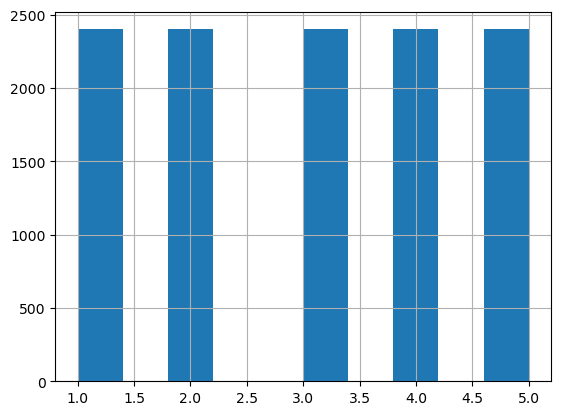

In [145]:
df['y'].hist()


The histogram shows five bars, each representing a unique value in the y column. These could correspond to different categories or classes of EEG signals.

The x-axis shows the unique values or class labels (1.0, 2.0, 3.0, 4.0, and 5.0).
The y-axis shows the frequency count for each class, which is how often each class label appears in the dataset.
The bars are almost the same height, indicating that the data is balanced across the five classes, meaning each class has a similar number of samples (around 2,400 to 2,500 samples per class).

<Axes: >

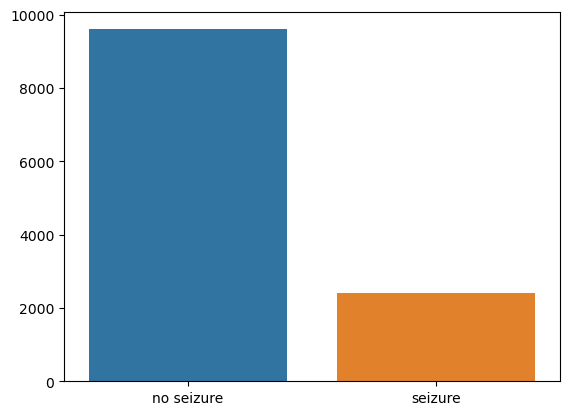

In [146]:
labels = ['no seizure', 'seizure']
seizure = np.sum(y == 1)
no_seizure = np.sum(y > 1)

sn.barplot(x=labels, y=[no_seizure, seizure])

In [147]:
print('The number of trials for the non-seizure class is:', no_seizure)
print('The number of trials for the seizure class is:', seizure)

The number of trials for the non-seizure class is: 9600
The number of trials for the seizure class is: 2400


In [148]:
Y = ESR.iloc[:,176].values
Y.shape

(12000,)

In [149]:
Y[Y>1]=0
Y

array([0., 0., 0., ..., 0., 1., 0.])

In [150]:
X = ESR.iloc[:,1:178].values
X.shape

(12000, 176)



### Data Pre-Processing

1. Haar Wavelet: Feature Extraction
Haar wavelet is a type of wavelet transformation used to analyze signals, including EEG data, at multiple scales.
It works by decomposing a signal into approximate and detailed components, capturing both low-frequency trends and high-frequency details.
Wavelet coefficients become the features fed to a machine learning model.
Purpose:

In EEG seizure detection, wavelets like Haar are useful because they capture both the short-term bursts (high-frequency) and longer trends (low-frequency) of the EEG signal, which are crucial for distinguishing between seizure and non-seizure states.
2. PCA (Principal Component Analysis): Dimensionality Reduction
PCA reduces the number of features (dimensions) while retaining as much variance (information) as possible.
EEG datasets are often high-dimensional after wavelet decomposition, which can make the model prone to overfitting. PCA simplifies the data by extracting only the most important components.
In this process:

PCA with 10 components reduces the data to 10 dimensions.
PCA with 50 components keeps 50 important dimensions.
Why PCA is used:

Reducing dimensions can improve model performance and reduce training time while still keeping meaningful patterns from the original data.
3. Different SVM Kernels: Model Training and Classification
After PCA, the reduced data is passed to an SVM model. The SVM classifier uses different kernels to find the optimal boundary between classes (seizure vs. non-seizure).

RBF Kernel (Radial Basis Function):
RBF is a non-linear kernel that maps the data into a higher-dimensional space where it becomes easier to separate the classes.

Works well when the relationship between the features and labels is non-linear.

Experiments:

RBF with 10-component PCA: Tests the model’s performance on data reduced to 10 dimensions.
RBF with 50-component PCA: Tests the model on a richer feature set with 50 components.
Polynomial Kernel:
A polynomial kernel computes a non-linear relationship by adding polynomial combinations of the input features.

It can model complex interactions between features but may be more computationally expensive than RBF.

Experiment:

Polynomial kernel with 50-component PCA: Uses 50-dimensional data and tries to capture non-linear relationships between features.
Summary of the Process:
Haar Wavelet: Extracts meaningful features from the raw EEG signal.
PCA: Reduces feature dimensions to either 10 or 50 components.
SVM with RBF/Polynomial Kernels:
RBF Kernel: Handles non-linear relationships effectively.
Polynomial Kernel: Models more complex relationships through polynomial interactions.
Performance Comparison:
By comparing different kernel-PCA combinations, the goal is to find the best combination that yields the highest accuracy, recall, precision, or F1-score for the task.


***Haar Wavelet***

*   RBF kernel with 10 component PCA
*   RBF kernel with 50 component PCA
*   Polynomial kernel with 50 component PCA










### Haar

In [151]:
X = ESR.iloc[:, :-1]

def apply_wavelet_transform(row):
    coeffs = pywt.wavedec(row, 'haar', level=2)
    return np.concatenate(coeffs)


wavelet_data = np.apply_along_axis(apply_wavelet_transform, axis=1, arr=X.to_numpy())


wavelet_df = pd.DataFrame(wavelet_data, columns=[f'wavelet_{i}' for i in range(len(wavelet_data[0]))])

wavelet_df['y'] = ESR['y']

print(wavelet_df.head())



   wavelet_0  wavelet_1  wavelet_2  wavelet_3  wavelet_4  wavelet_5  \
0     -167.0       14.0      -35.0     -165.5      -27.5      -42.0   
1       41.0      -29.5      -93.5     -104.0     -114.5     -100.0   
2        2.5       41.5      111.0       54.5      -93.0     -136.0   
3     -652.0     -815.5    -1044.5      136.0      641.0      903.0   
4      -34.0      -29.5        5.0       -5.5       36.5      106.0   

   wavelet_6  wavelet_7  wavelet_8  wavelet_9  ...  wavelet_167  wavelet_168  \
0     -219.5       38.0       69.0      -77.0  ...   -17.677670     2.121320   
1     -100.0      -71.5      -83.5      -78.5  ...    -9.899495     1.414214   
2     -115.5       29.0      -11.0      -64.5  ...    -9.192388     7.778175   
3     1220.0      557.0     -420.5     -895.5  ...    76.367532    46.669048   
4      109.0       72.0       65.0       63.5  ...    21.920310   -31.112698   

   wavelet_169  wavelet_170  wavelet_171  wavelet_172  wavelet_173  \
0     0.000000     7.7

 **Data Scaling**

In [152]:
X = wavelet_df.iloc[:, :-1]
y = wavelet_df['y']

num_bins = 5
y_categorical = pd.cut(y, bins=num_bins, labels=False)


scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)


**PCA with 10 components**

In [153]:
# Apply PCA
n_components = 10
pca1 = PCA(n_components=n_components)
X_pca1 = pca1.fit_transform(X_standardized)

pca_df1 = pd.DataFrame(data=X_pca1, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df1['y'] = y_categorical

print(pca_df1.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.491663 -0.306765  0.892603  1.461184 -1.459361  0.275340 -0.383457   
1  0.118070 -0.042930  0.103516 -0.154581  0.050848 -0.054650 -0.216454   
2 -0.070815  0.075663 -0.286934  0.514674  0.132424 -0.031392 -0.614289   
3  1.400871  5.322310 -3.321285 -4.839162  5.026267  3.068814 -1.379216   
4  0.354375  0.609584  0.430779  0.147729 -1.587247 -0.811835 -0.089187   

        PC8       PC9      PC10  y  
0  0.137859 -0.393484  0.363043  0  
1  0.096902 -0.070218 -0.391903  0  
2  0.126380 -0.079977  0.565491  0  
3 -1.344501 -0.189028  7.567831  0  
4 -1.112950 -0.218575 -0.226199  0  


**Data splitting**

In [154]:
X_train, X_temp, y_train, y_temp = train_test_split(
    pca_df1.iloc[:, :-1],
    pca_df1['y'],
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42
)


**SVM with RBF kernel**

In [155]:
svm = SVC()


param_grid = {
    'C': [0.1, 10],
    'kernel': [ 'rbf'],
}

In [156]:
print("Classes présentes dans y_val :", np.unique(y_val))
print("Classes présentes dans y_test :", np.unique(y_test))

Classes présentes dans y_val : [0 4]
Classes présentes dans y_test : [0 4]


In [157]:
print("Distribution des classes (Validation) :", dict(zip(*np.unique(y_val, return_counts=True))))
print("Distribution des classes (Test) :", dict(zip(*np.unique(y_test, return_counts=True))))


Distribution des classes (Validation) : {0: 1418, 4: 382}
Distribution des classes (Test) : {0: 1449, 4: 351}


In [158]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_


best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Prédictions sur les ensembles de validation et de test
y_val_pred = best_svm.predict(X_val)
y_test_pred = best_svm.predict(X_test)

# Calcul des métriques pour l’ensemble de validation
val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred, average='macro')
val_precision = precision_score(y_val, y_val_pred, average='macro')
val_f1 = f1_score(y_val, y_val_pred, average='macro')

# Calcul des métriques pour l’ensemble de test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [159]:
# Affichage des résultats
print(f"\nBest Hyperparameters: {best_params}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Best Hyperparameters: {'C': 0.1, 'kernel': 'rbf'}
Validation Accuracy: 0.7878
Validation Recall: 0.5000
Validation Precision: 0.3939
Validation F1 Score: 0.4406
Test Accuracy: 0.8050
Test Recall: 0.5000
Test Precision: 0.4025
Test F1 Score: 0.4460


**PCA with 50 components**

In [160]:
n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)


pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['y'] = y_categorical


print(pca_df.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.490529 -0.301733  0.872491  1.435115 -1.442837  0.272436 -0.370484   
1  0.118431 -0.045057  0.105669 -0.152561  0.057872 -0.043612 -0.221590   
2 -0.071872  0.080106 -0.299627  0.489411  0.124732 -0.059033 -0.601013   
3  1.392762  5.332407 -3.419175 -4.804313  4.921890  3.231304 -1.570721   
4  0.354585  0.603351  0.423001  0.163948 -1.586234 -0.738801 -0.137463   

        PC8       PC9      PC10  ...      PC42      PC43      PC44      PC45  \
0  0.178726 -0.456315  0.313247  ...  0.309861  0.217899  0.535883 -0.009726   
1  0.087474 -0.071882  0.038647  ...  0.323854  0.611628  0.064652 -0.203203   
2  0.173498 -0.104971  0.259972  ...  0.061338  0.157473 -0.001629 -0.367787   
3 -1.011457 -0.819192  8.301415  ... -0.556140  4.400409  2.773813  1.219583   
4 -1.125973 -0.301204 -0.694847  ... -0.092240  0.069515  0.140477  1.168045   

       PC46      PC47      PC48      PC49      PC50  y  
0 -0.302726

In [161]:
X_train, X_temp, y_train, y_temp = train_test_split(
    pca_df.iloc[:, :-1],
    pca_df['y'],
    test_size=0.3,
    random_state=42
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42
)


**SVM with RBF kernel**

In [162]:
svm = SVC()


param_grid = {
    'C': [1, 10],
    'kernel': [ 'rbf'],
}


In [163]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_


best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Prédictions sur les ensembles de validation et de test
y_val_pred = best_svm.predict(X_val)
y_test_pred = best_svm.predict(X_test)

# Calcul des métriques pour l’ensemble de validation
val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred, average='macro')
val_precision = precision_score(y_val, y_val_pred, average='macro')
val_f1 = f1_score(y_val, y_val_pred, average='macro')

# Calcul des métriques pour l’ensemble de test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')




c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [164]:
print(f"\nBest Hyperparameters: {best_params}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}
Validation Accuracy: 0.7878
Validation Recall: 0.5000
Validation Precision: 0.3939
Validation F1 Score: 0.4406
Test Accuracy: 0.8056
Test Recall: 0.5014
Test Precision: 0.9027
Test F1 Score: 0.4490


**SVM with poly kernel**

In [165]:
svm = SVC()


param_grid = {
    'C': [0.1, 10],
    'kernel': [ 'poly'],
}

In [166]:

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_


best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Prédictions sur les ensembles de validation et de test
y_val_pred = best_svm.predict(X_val)
y_test_pred = best_svm.predict(X_test)

# Calcul des métriques pour l’ensemble de validation
val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred, average='macro')
val_precision = precision_score(y_val, y_val_pred, average='macro')
val_f1 = f1_score(y_val, y_val_pred, average='macro')

# Calcul des métriques pour l’ensemble de test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')


c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
print(f"\nBest Hyperparameters: {best_params}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Best Hyperparameters: {'C': 0.1, 'kernel': 'poly'}
Validation Accuracy: 0.7878
Validation Recall: 0.5000
Validation Precision: 0.3939
Validation F1 Score: 0.4406
Test Accuracy: 0.8050
Test Recall: 0.5000
Test Precision: 0.4025
Test F1 Score: 0.4460


**Symlet Wavelet**


*   PCA with 50 components and RBF kernel for SVM
*   PCA with 50 components and Poly kernel for SVM




### Symlet8

In [168]:

X = ESR.iloc[:, :-1]


def apply_wavelet_transform(row, wavelet_name='sym8', level=2):
    coeffs = pywt.wavedec(row, wavelet_name, level=level)
    return np.concatenate(coeffs)


wavelet_data = np.apply_along_axis(apply_wavelet_transform, axis=1, arr=X.to_numpy())


wavelet_df = pd.DataFrame(wavelet_data, columns=[f'wavelet_{i}' for i in range(len(wavelet_data[0]))])


wavelet_df['y'] = ESR['y']


print(wavelet_df.head())



    wavelet_0   wavelet_1   wavelet_2   wavelet_3   wavelet_4   wavelet_5  \
0  -94.756346 -165.398076 -116.153324  -32.433631 -158.636329 -179.198115   
1   -3.985286   60.547166   10.153672  -25.652867   49.740349   37.747908   
2   23.411090   -9.694345   15.851554   28.711176   -2.983404   -2.099400   
3 -820.779605 -497.543176 -771.921118 -838.501161 -567.434650 -665.818999   
4  -30.002663  -30.687820  -30.425846  -24.443170  -31.653690  -28.687429   

    wavelet_6    wavelet_7   wavelet_8   wavelet_9  ...  wavelet_196  \
0   43.021692   -60.831785 -172.584640   21.481411  ...     3.798133   
1  -28.453836   -96.097605 -105.338209 -112.397992  ...    -0.177071   
2   46.817731   122.945772   40.073038  -84.189358  ...     3.271679   
3 -838.203769 -1146.254768  283.733813  584.307345  ...    -3.815564   
4  -40.553062    16.590842  -24.820816   57.570123  ...     0.961533   

   wavelet_197  wavelet_198  wavelet_199  wavelet_200  wavelet_201  \
0    -2.749268     0.134112    -0.

In [169]:
X = wavelet_df.iloc[:, :-1]
y = wavelet_df['y']


num_bins = 5
y_categorical = pd.cut(y, bins=num_bins, labels=False)


scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

In [170]:
n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)


pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['y'] = y_categorical


print(pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.217236  0.207573  0.621366 -0.169177  0.973512 -1.977897  2.501239   
1 -0.426369  0.249221 -0.376759 -0.087098 -0.119016  0.983040  0.019004   
2 -0.030357 -0.540689  0.175742  1.129250  0.328519 -1.184048  0.680726   
3  6.672086  2.289375  4.786819  2.895688 -1.342744  4.629337  2.612463   
4  0.571350  0.312324  0.077724  0.170616  0.303093 -1.427722  0.222655   

        PC8       PC9      PC10  ...      PC42      PC43      PC44      PC45  \
0 -2.063841 -0.326040  1.043804  ... -0.347264 -1.146311  0.719601  0.461705   
1  0.328475 -0.217044 -0.490473  ... -0.576814 -0.280307  0.437754 -0.311253   
2 -1.473914 -1.111026 -0.385950  ... -0.020384 -0.715898  0.243148 -0.187037   
3 -2.554603 -0.601509  4.509989  ... -2.271487  1.071547  3.086380  0.196733   
4 -1.025753 -0.533325 -0.321148  ...  0.068568 -0.472654 -0.396972 -0.204154   

       PC46      PC47      PC48      PC49      PC50  y  
0 -0.199933

In [171]:
X_train, X_temp, y_train, y_temp = train_test_split(
    pca_df.iloc[:, :-1],
    pca_df['y'],
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42
)

**SVM with polynomial kernel**

In [172]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': [ 'poly'],
}


In [173]:

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

y_val_pred = best_svm.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred, pos_label=4)
val_precision = precision_score(y_val, y_val_pred, pos_label=4)
val_f1 = f1_score(y_val, y_val_pred, pos_label=4)



y_test_pred = best_svm.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, pos_label=4)
test_precision = precision_score(y_test, y_test_pred, pos_label=4)
test_f1 = f1_score(y_test, y_test_pred, pos_label=4)




c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [174]:
print(f"\nBest Hyperparameters: {best_params}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Best Hyperparameters: {'C': 0.1, 'kernel': 'poly'}
Validation Accuracy: 0.7872
Validation Recall: 0.0000
Validation Precision: 0.0000
Validation F1 Score: 0.0000
Test Accuracy: 0.8050
Test Recall: 0.0000
Test Precision: 0.0000
Test F1 Score: 0.0000


**SVM with RBF**

In [175]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': [ 'rbf'],
}


In [176]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

y_val_pred = best_svm.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred, pos_label=4)
val_precision = precision_score(y_val, y_val_pred, pos_label=4)
val_f1 = f1_score(y_val, y_val_pred, pos_label=4)



y_test_pred = best_svm.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, pos_label=4)
test_precision = precision_score(y_test, y_test_pred, pos_label=4)
test_f1 = f1_score(y_test, y_test_pred, pos_label=4)



In [177]:
print(f"\nBest Hyperparameters: {best_params}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}
Validation Accuracy: 0.7917
Validation Recall: 0.0419
Validation Precision: 0.6400
Validation F1 Score: 0.0786
Test Accuracy: 0.8044
Test Recall: 0.0142
Test Precision: 0.4545
Test F1 Score: 0.0276


**Daubechies wavelet**



*   PCA with 50 components and RBF kernel for SVM
*   PCA with 50 components and Poly kernel for SVM




### Daubechies wavelet

In [178]:

X = ESR.iloc[:, :-1]

def apply_wavelet_transform(row, wavelet_name='db4', level=2):
    coeffs = pywt.wavedec(row, wavelet_name, level=level)
    return np.concatenate(coeffs)

wavelet_data = np.apply_along_axis(apply_wavelet_transform, axis=1, arr=X.to_numpy())

wavelet_df = pd.DataFrame(wavelet_data, columns=[f'wavelet_{i}' for i in range(len(wavelet_data[0]))])

wavelet_df['y'] = ESR['y']

print(wavelet_df.head())


    wavelet_0   wavelet_1   wavelet_2   wavelet_3   wavelet_4   wavelet_5  \
0 -139.365716 -165.292088 -116.195690 -138.928727 -196.025140   17.941007   
1   20.777514   56.970486   -5.112804   39.634414   45.970650  -18.221731   
2   11.796269   -9.340355   26.587659   -0.296606   -3.163374   37.209788   
3 -747.803050 -520.905070 -882.737632 -590.812968 -657.126269 -771.582995   
4  -31.130686  -32.475232  -25.799224  -30.150530  -28.513503  -42.424100   

     wavelet_6   wavelet_7   wavelet_8   wavelet_9  ...  wavelet_180  \
0   -26.597896 -174.943632  -12.857791  -44.445198  ...     3.317370   
1   -91.876620 -104.452848 -113.100216 -101.435572  ...     2.557352   
2   115.018243   62.509746  -74.200041 -138.112305  ...    -1.871277   
3 -1203.460028  103.593542  602.299166  829.375886  ...     0.584266   
4    10.833409  -17.953817   40.827310   98.267457  ...    -3.823265   

   wavelet_181  wavelet_182  wavelet_183  wavelet_184  wavelet_185  \
0    -0.568797     0.626409    -4.

In [179]:
X = wavelet_df.iloc[:, :-1]
y = wavelet_df['y']


num_bins = 5
y_categorical = pd.cut(y, bins=num_bins, labels=False)


scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)



**PCA with 50 components**

In [180]:
n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)


pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['y'] = y_categorical


print(pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.705175 -1.850401  0.224531 -0.605401 -0.138704 -0.327483 -0.262843   
1 -0.201176  0.046075 -0.509491 -0.574713 -0.085652  0.282143  0.343744   
2 -0.121263  0.161119 -0.634300  0.474027  0.308552 -0.115233  0.370926   
3  2.417860 -5.151474 -2.381547  1.582681  5.828093  1.777775 -1.547139   
4  0.131850 -0.061095  0.572563  0.927272  0.312437 -0.676784  0.682769   

        PC8       PC9      PC10  ...      PC42      PC43      PC44      PC45  \
0  0.173005 -1.055938 -0.144578  ...  1.127400 -0.756992  1.530777 -1.835033   
1 -0.163697 -0.313750 -0.278228  ...  0.503745 -0.194247  0.027633  0.108266   
2  0.576411 -0.318601 -0.782228  ...  0.464072 -0.570603  0.491977  0.182091   
3 -2.175000 -0.005089  0.525074  ...  2.715677 -3.970058  0.524008  0.600474   
4 -0.177226  1.253280  0.409684  ...  0.102506 -0.533012  0.088081 -0.413559   

       PC46      PC47      PC48      PC49      PC50  y  
0  0.016265

In [181]:
X_train, X_temp, y_train, y_temp = train_test_split(
    pca_df.iloc[:, :-1],
    pca_df['y'],
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42
)


**SVM with Poly kernel**

In [182]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': [ 'poly'],
}

In [183]:

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

y_val_pred = best_svm.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred, pos_label=4)
val_precision = precision_score(y_val, y_val_pred, pos_label=4)
val_f1 = f1_score(y_val, y_val_pred, pos_label=4)

y_test_pred = best_svm.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, pos_label=4)
test_precision = precision_score(y_test, y_test_pred, pos_label=4)
test_f1 = f1_score(y_test, y_test_pred, pos_label=4)


c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hyperparameters for training with daubechies wavelet and poly kernel for SVM

In [184]:

print(f"\nBest Hyperparameters: {best_params}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")



Best Hyperparameters: {'C': 0.1, 'kernel': 'poly'}
Validation Accuracy: 0.7878
Validation Recall: 0.0000
Validation Precision: 0.0000
Validation F1 Score: 0.0000
Test Accuracy: 0.8050
Test Recall: 0.0000
Test Precision: 0.0000
Test F1 Score: 0.0000


**SVM with RBF kernel**

In [185]:

svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': [ 'rbf'],
}

In [186]:

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)


y_val_pred = best_svm.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred, pos_label=4)
val_precision = precision_score(y_val, y_val_pred, pos_label=4)
val_f1 = f1_score(y_val, y_val_pred, pos_label=4)

y_test_pred = best_svm.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, pos_label=4)
test_precision = precision_score(y_test, y_test_pred, pos_label=4)
test_f1 = f1_score(y_test, y_test_pred, pos_label=4)



c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hyperparameters for training with daubechies wavelet and RBF kernel for SVM

In [187]:
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Validation Accuracy: 0.7878
Validation Recall: 0.0000
Validation Precision: 0.0000
Validation F1 Score: 0.0000
Test Accuracy: 0.8050
Test Recall: 0.0000
Test Precision: 0.0000
Test F1 Score: 0.0000


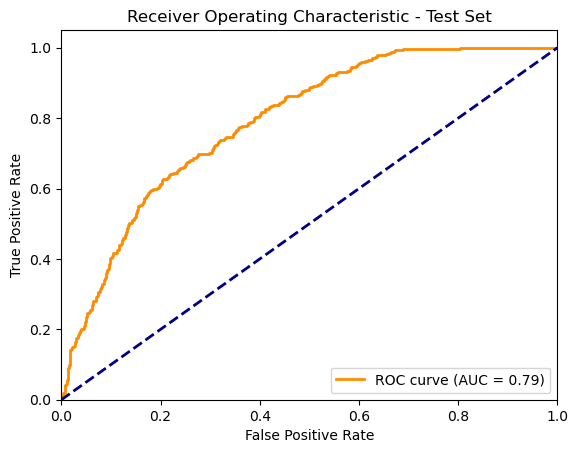

In [188]:

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, best_svm.decision_function(X_test), pos_label=4)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()


In [189]:
import numpy as np
import pandas as pd  # Ensure pandas is imported
import pywt  # For wavelet decomposition
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, mean_squared_error
from pyswarms.single import GlobalBestPSO  # For PSO feature selection

# Load the EEG dataset (A-E BONN dataset)
ESR = pd.read_csv('C:/Users/MSI/Desktop/Dasec Mini Projet/DataBase/datafinal.csv')

# Separate features and labels
X = ESR.drop(columns=['y'])
y = ESR['y']

# Wavelet decomposition function
def wavelet_decomposition(signal, wavelet='db4'):
    coeffs = pywt.wavedec(signal, wavelet, level=4)
    return np.concatenate(coeffs)

# Apply wavelet decomposition to each row
X_wavelet = np.array([wavelet_decomposition(x.values.flatten()) for _, x in X.iterrows()])

# PSO Feature Selection
def pso_feature_selection(X, y, n_particles=10, max_iter=30):
    def fitness_function(selected_features):
        selected_indices = np.where(selected_features > 0.5)[0]
        X_selected = X[:, selected_indices]
        if X_selected.shape[1] == 0:  # No features selected
            return np.inf
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
        model = LinearRegression().fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)
    
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=X.shape[1], options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
    cost, pos = optimizer.optimize(fitness_function, iters=max_iter)
    return np.where(pos > 0.5)[0]

selected_features = pso_feature_selection(X_wavelet, y)
X_selected = X_wavelet[:, selected_features]

# Train and evaluate classifiers
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Linear Regression MSE:', mean_squared_error(y_test, y_pred_lr))

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print('K-NN Accuracy:', accuracy_score(y_test, y_pred_knn))

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=2).fit(X_train)
y_pred_gmm = gmm.predict(X_test)
print('GMM Accuracy:', accuracy_score(y_test, y_pred_gmm))

# Non-Linear Regression (Polynomial)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2
nlr = make_pipeline(PolynomialFeatures(degree), LinearRegression())
nlr.fit(X_train, y_train)
y_pred_nlr = nlr.predict(X_test)
print('Non-Linear Regression MSE:', mean_squared_error(y_test, y_pred_nlr))


2024-10-22 00:11:36,617 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=2.01
2024-10-22 00:13:08,267 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.005855661028982, best pos: [1.3285629  0.67149934 0.92388929 0.52819914 1.59768225 1.17020158
 1.30724193 0.53167514 0.44051132 1.83877979 1.54999533 1.84838194
 0.47734369 1.05010085 0.91131357 1.14040945 0.63238386 1.30590201
 0.35048796 1.79798439 0.38643342 1.68693874 0.42522482 1.08601632
 1.52441426 1.54825594 0.69105338 2.46475606 1.95240459 1.59031983
 0.78082999 1.22262289 1.09518946 1.20109527 0.46117921 0.92775148
 0.57939491 2.57333911 0.89143608 1.68420936 1.29618448 0.64562121
 1.29054089 1.44891259 1.09103086 0.555011   0.79528755 1.92091369
 1.18186954 1.33582051 1.4247606  2.05707683 0.08635983 1.34855935
 1.21646195 0.4510938  0.55831267 0.96449047 0.71682446 1.27724384
 0.72873544 0

Linear Regression MSE: 2.06802089665727
K-NN Accuracy: 0.44916666666666666
GMM Accuracy: 0.016944444444444446
Non-Linear Regression MSE: 5547393.924032728
